# Faux dataset RDS package

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import pystan as ps
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
import arviz as az
sns.set()

In [2]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/prevalence_estimation/pickles/RDS_B_estimator.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/prevalence_estimation/stan_codes/RDS_B_estimator.stan')
    with open('../models/prevalence_estimation/pickles/RDS_B_estimator.pkl', 'wb') as f:
        pickle.dump(sm, f)
        
rds_model = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'rb'))

In [3]:
faux_data = pd.read_csv('../data/faux.csv', index_col=0)
faux_data.head()

,id,recruiter.id,X,Y,Z,network.size,wave,seed,weights,hat_X
1,735,seed,red,black,red,16,0,735,2.413615,0
2,134,735,blue,black,red,20,1,735,2.067591,1
3,168,735,red,black,red,17,1,735,2.327383,1
4,111,134,blue,black,red,32,2,735,1.537643,1
5,220,134,blue,black,red,14,2,735,2.685803,1


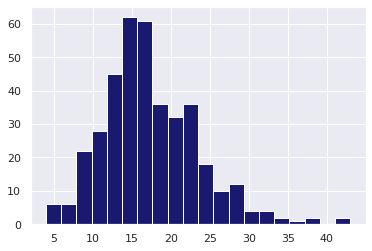

In [4]:
plt.hist(faux_data['network.size'], bins=20, color='midnightblue')
plt.savefig('../images/degree_distribution_fauxdata.pdf', bbox_inches='tight')
plt.show()

In [5]:
G = nx.DiGraph() 
for i, data in faux_data.iterrows():
    G.add_node(data['id'], X=data['X'], Y=data['Y'], Z=data['Z'], degree=data['network.size'])
    if data['recruiter.id'] != 'seed':
        G.add_edge(int(data['recruiter.id']), data['id'])

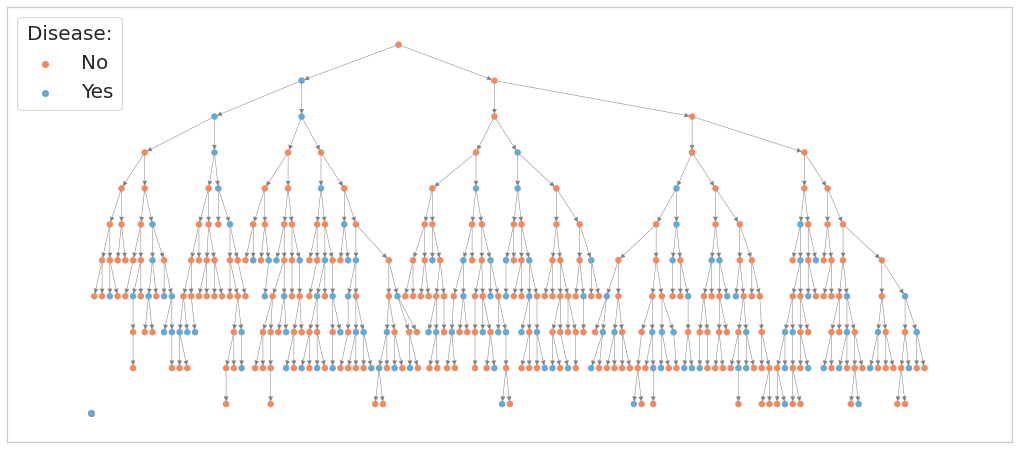

In [6]:
color_map = {'red': "#ef8a62", 'blue': "#67a9cf"}
colors = [color_map[c] for c in list(nx.get_node_attributes(G, 'X').values())]

options = {
    'node_color': colors,
    'node_size': 30,
    'with_labels': False,
    'font_weight': 'bold',
    'edge_color': 'grey',
    'width': 0.5
}

sns.set(style='whitegrid')
plt.figure(figsize = (18,8))
pos = graphviz_layout(G, prog="dot")

for label in ['red', 'blue']:
    plt.scatter([0],[0], color=color_map[label], label={'red':'No', 'blue':'Yes'}[label])

nx.draw_networkx(G, pos, **options)

plt.grid(False)
legend = plt.legend(loc="upper left", title = "Disease:", prop = {'size': 20})
plt.setp(legend.get_title(),fontsize=20)
plt.savefig('../images/rds_erdos_renyi_experiment1.pdf', bbox_inches = 'tight')
plt.show()

sns.set()

In [26]:
%%time
data = {'n_samples': 389, 
        'Y': faux_data['hat_X'],
        'mu_alpha': 0, 
        'sigma_alpha': 5,
        'delta': 389 * (1/faux_data['network.size'])/(1/faux_data['network.size']).sum()}
    
fit = sm.sampling(data=data)

CPU times: user 44.1 ms, sys: 33.5 ms, total: 77.5 ms
Wall time: 576 ms


In [30]:
spec = 0.85
sens = 0.9
(np.mean(fit.extract()['theta']) - (1-spec))/(sens+spec-1)

0.334039652342997

In [10]:
faux_data['Z_num'] = 1*(faux_data['Z'] == 'red')
faux_data['Y_num_1'] = 1*(faux_data['Y'] == 'black')
faux_data['Y_num_2'] = 1*(faux_data['Y'] == 'blue')

In [11]:
A = nx.adjacency_matrix(G.to_undirected()).toarray() 
data = {
    "n_samples"    : 389,
    "n_predictors" : 3,
    "Y"            : faux_data['hat_X'],
    "X"            : faux_data[['Z_num', 'Y_num_1', 'Y_num_2']],
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

In [15]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(3),
    "mu"           : np.zeros(3),
    "alpha_p"      : 3,
    "beta_p"       : 7,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 8.5,
    "beta_e"       : 1.5,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [16]:
fit = rds_model.sampling(data=data, warmup=1500, iter=2500, pars=('prev', 'sens', 'spec', 'tau', 'effects'), 
                         control={'adapt_delta': 0.95})

In [ ]:
fit

Inference for Stan model: anon_model_d03c9865b540cd990e759264a2a431f3.
4 chains, each with iter=2500; warmup=1500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prev         0.26  2.2e-3   0.12   0.07   0.17   0.25   0.34   0.51   2881    1.0
sens         0.89  9.6e-4   0.07   0.72   0.85    0.9   0.94   0.98   5449    1.0
spec         0.79  2.7e-3    0.1   0.63   0.71   0.78   0.87   0.98   1321    1.0
tau         3.0e4   2.5e4  1.6e6    0.5    3.6  13.19  79.91 9175.3   4000    1.0
effects[1]   -0.3    0.02    0.7  -1.77  -0.72  -0.26   0.18   0.99   2127    1.0
effects[2]   0.24    0.01    0.6  -1.09  -0.09   0.26   0.62   1.37   2577    1.0
effects[3]  -0.12    0.01    0.7  -1.61  -0.55  -0.08   0.34   1.17   2237    1.0
lp__       -493.6    2.62  26.76 -560.2 -506.4 -489.2 -475.7 -453.8    104   1.02

Samples were drawn using NUTS at Wed Nov 24 16:06:31 2021.
For each para

In [19]:
faux_madrona_data = pd.read_csv('../data/faux_madrona.csv', index_col=0)
faux_sycamore_data = pd.read_csv('../data/faux_sycamore.csv', index_col=0)
faux_madrona_data.head()

,id,recruiter.id,degree,disease,todiseased,tonondiseased,wave,seed,weights,test
194,194,seed,11,1,5,6,0,194,1.486342,0
298,298,seed,7,0,1,6,0,298,1.954231,0
164,164,seed,8,1,6,2,0,164,1.789708,1
617,617,seed,8,0,0,8,0,617,1.789708,0
586,586,seed,4,0,1,3,0,586,2.983005,0


In [77]:
%%time
data = {'n_samples': 500, 
        'Y': faux_sycamore_data['test'],
        'mu_alpha': 0, 
        'sigma_alpha': 5,
        'delta': 500 * (1/faux_sycamore_data['degree'])/(1/faux_sycamore_data['degree']).sum()}
    
fit = sm.sampling(data=data)

CPU times: user 46.5 ms, sys: 49.1 ms, total: 95.6 ms
Wall time: 742 ms


In [78]:
(np.mean(fit.extract()['theta']) - (1-spec))/(sens+spec-1)

0.16392880138377283

In [79]:
fit.extract()['theta'].mean()

0.27294660103782964

In [177]:
G = nx.DiGraph() 
for i, data in faux_sycamore_data.iterrows():
    G.add_node(data['id'], degree=data['degree'])
    if data['recruiter.id'] != 'seed':
        G.add_edge(int(data['recruiter.id']), data['id'])

In [178]:
A = nx.adjacency_matrix(G.to_undirected()).toarray() 
X = np.random.normal(0,1,size=(500,1))
data = {
    "n_samples"    : 500,
    "n_predictors" : 1,
    "Y"            : faux_sycamore_data['test'],
    "X"            : 0.5 * (X - X.mean())/X.std(ddof=1),
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

In [184]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : 0.001 * np.eye(1),
    "mu"           : np.zeros(1),
    "alpha_p"      : 2,
    "beta_p"       : 8,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 8.5,
    "beta_e"       : 1.5,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [185]:
fit = rds_model.sampling(data=data, warmup=3500, iter=4500, pars=('prev', 'sens', 'spec', 'tau', 'effects'), 
                         control={'adapt_delta': 0.8, 'max_treedepth': 10})

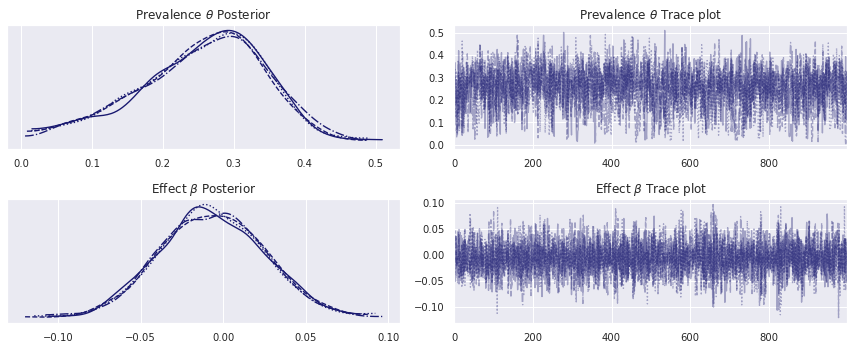

In [186]:
fig, ax = plt.subplots(2,2, figsize = (12, 5))
az.plot_trace(fit, var_names=('prev', 'effects'),  chain_prop={'color': ['midnightblue'], 'linestyle': ['-', ':', '-.', '--']},
              axes=ax)

ax[0,0].set_title(r'Prevalence $\theta$ Posterior')
ax[1,0].set_title(r'Effect $\beta$ Posterior')
ax[0,1].set_title(r'Prevalence $\theta$ Trace plot')
ax[1,1].set_title(r'Effect $\beta$ Trace plot')
fig.tight_layout(pad = 1)

#plt.savefig('../images/rds_model_faux_sycamore_traceplot.pdf', bbox_inches='tight')
plt.show()

In [188]:
fit

Inference for Stan model: anon_model_d03c9865b540cd990e759264a2a431f3.
4 chains, each with iter=4500; warmup=3500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
prev          0.25  3.0e-3   0.09   0.06    0.2    0.26   0.32   0.41    939   1.01
sens           0.9  1.1e-3   0.07   0.74   0.86    0.91   0.95   0.99   3687    1.0
spec          0.86  4.6e-3   0.09   0.68    0.8    0.87   0.93   0.99    361   1.01
tau         4637.1  2254.4  1.4e5   0.18   0.99    4.21  24.04 3000.9   3679    1.0
effects[1] -6.6e-3  4.1e-4   0.03  -0.07  -0.03 -6.8e-3   0.01   0.06   5997    1.0
lp__        -621.9    4.44  38.55 -705.9 -645.1  -616.4 -595.3 -555.0     75   1.06

Samples were drawn using NUTS at Wed Nov 24 20:03:00 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).